# Chapter 5 : Classification – Detecting Poor Answers


<ul>
    <li>Name: Gyanas Luitel</li>
    <li>Group: Computer Science</li>
    <li>Roll No: 27</li>

</ul>

### Importing 

In [1]:
from matplotlib import pylab
import numpy as np
import os
from scipy.stats import norm
from matplotlib import pyplot

In [2]:
import sys
import re

try:
    import ujson as json  # UltraJSON if available
except:
    import json
    
from dateutil import parser as dateparser

from operator import itemgetter
from xml.etree import cElementTree as etree
from collections import defaultdict, Mapping, Counter


<ipython-input-2-bac4f6a61535>:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import defaultdict, Mapping, Counter


## Fetching the data

In [3]:
DATA_DIR="./Lab5/data"

#filename = os.path.join(DATA_DIR, "posts-2011-12.xml")
filename = os.path.join(DATA_DIR, "Posts.xml")
print(f"Reading from xml {filename}")
filename_filtered = os.path.join(DATA_DIR, "filtered.tsv")
print(f"Filtered: {filename_filtered}")
filename_filtered_meta = os.path.join(DATA_DIR, "filtered-meta.json")
print(f"Meta: {filename_filtered_meta}")

q_creation = {}  # creation datetimes of questions
q_accepted = {}  # id of accepted answer

# question -> [(answer Id, IsAccepted, TimeToAnswer, Score), ...]
meta = defaultdict(list)

Reading from xml ./Lab5/data/Posts.xml
Filtered: ./Lab5/data/filtered-meta.tsv
Meta: ./Lab5/data/filtered-meta.json


## Starting with kNN

In [4]:
from sklearn import neighbors

In [5]:
knn = neighbors.KNeighborsClassifier(n_neighbors=2)
knn

KNeighborsClassifier(n_neighbors=2)

In [6]:
knn.fit([[1],[2],[3],[4],[5],[6]], [0,0,0,1,1,1])

KNeighborsClassifier(n_neighbors=2)

In [7]:
knn.predict([[1.5]])

array([0])

In [8]:
knn.predict([[37]])

array([1])

In [12]:
knn.predict([[3]])

array([0])

In [13]:
knn.predict_proba([[1.5]])

array([[1., 0.]])

In [14]:
knn.predict_proba([[37]])

array([[0., 1.]])

In [15]:
knn.predict_proba([[3.5]])

array([[0.5, 0.5]])

### Engineering the features

In [16]:
# regegx to find code snippets
code_match = re.compile('<pre>(.*?)</pre>', re.MULTILINE | re.DOTALL)
link_match = re.compile(
    '<a href="http://.*?".*?>(.*?)</a>', re.MULTILINE | re.DOTALL)
img_match = re.compile('<img(.*?)/>', re.MULTILINE | re.DOTALL)
tag_match = re.compile('<[^>]*>', re.MULTILINE | re.DOTALL)

In [17]:
def extract_features_from_body(s):
    link_count_in_code = 0
    # count links in code to later subtract them
    for match_str in code_match.findall(s):
        link_count_in_code += len(link_match.findall(match_str))
    return len(link_match.findall(s)) - link_count_in_code


In [18]:
def filter_html(s):
    num_code_lines = 0
    link_count_in_code = 0
    code_free_s = s

    num_images = len(img_match.findall(s))

    # remove source code and count how many lines
    for match_str in code_match.findall(s):
        num_code_lines += match_str.count('\n')
        code_free_s = code_match.sub("", code_free_s)

        # sometimes source code contain links, which we don't want to count
        link_count_in_code += len(link_match.findall(match_str))

    links = link_match.findall(s)
    link_count = len(links)

    link_count -= link_count_in_code

    link_free_s = re.sub(
        " +", " ", tag_match.sub('', code_free_s)).replace("\n", "")

    for link in links:
        if link.lower().startswith("http://"):
            link_free_s = link_free_s.replace(link, '')

    num_text_tokens = link_free_s.count(" ")

    return link_free_s, num_text_tokens, num_code_lines, link_count, num_images

In [22]:
years = defaultdict(int)
num_questions = 0
num_answers = 0

if sys.version_info.major < 3:
    # Python 2, map() returns a list, which will lead to out of memory errors.
    # The following import ensures that the script behaves like being executed
    # with Python 3.
    from itertools import imap as map


def parsexml(filename):
    global num_questions, num_answers

    counter = 0

    it = map(itemgetter(1),
             iter(etree.iterparse(filename, events=('start',))))

    root = next(it)  # get posts element

    for elem in it:
        if counter % 100000 == 0:
            print("Processed %i <row/> elements" % counter)

        counter += 1

        if elem.tag == 'row':
            creation_date = dateparser.parse(elem.get('CreationDate'))

            Id = int(elem.get('Id'))
            PostTypeId = int(elem.get('PostTypeId'))
            Score = int(elem.get('Score'))

            if PostTypeId == 1:
                num_questions += 1
                years[creation_date.year] += 1

                ParentId = -1
                TimeToAnswer = 0
                q_creation[Id] = creation_date
                accepted = elem.get('AcceptedAnswerId')
                if accepted:
                    q_accepted[Id] = int(accepted)
                IsAccepted = 0

            elif PostTypeId == 2:
                num_answers += 1

                ParentId = int(elem.get('ParentId'))
                if not ParentId in q_creation:
                    # question was too far in the past
                    continue

                TimeToAnswer = (creation_date - q_creation[ParentId]).seconds

                if ParentId in q_accepted:
                    IsAccepted = int(q_accepted[ParentId] == Id)
                else:
                    IsAccepted = 0

                meta[ParentId].append((Id, IsAccepted, TimeToAnswer, Score))

            else:
                continue

            Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = filter_html(
                elem.get('Body'))

            values = (Id, ParentId,
                      IsAccepted,
                      TimeToAnswer, Score,
                      Text.encode("utf-8"),
                      NumTextTokens, NumCodeLines, LinkCount, NumImages)

            yield values

            root.clear()  # preserve memory

with open(filename_filtered, "w") as f:
    for values in parsexml(filename):
        line = "\t".join(map(str, values))
        f.write(line + "\n")

with open(filename_filtered_meta, "w") as f:
    json.dump(meta, f)

print("years:", years)
print(f"#qestions: {num_questions}")
print(f"#answers: {num_answers}")

Processed 0 <row/> elements
Processed 100000 <row/> elements
Processed 200000 <row/> elements
Processed 300000 <row/> elements
Processed 400000 <row/> elements
Processed 500000 <row/> elements
Processed 600000 <row/> elements
Processed 700000 <row/> elements
Processed 800000 <row/> elements
Processed 900000 <row/> elements
Processed 1000000 <row/> elements
Processed 1100000 <row/> elements
Processed 1200000 <row/> elements
Processed 1300000 <row/> elements
Processed 1400000 <row/> elements
Processed 1500000 <row/> elements
Processed 1600000 <row/> elements
Processed 1700000 <row/> elements
Processed 1800000 <row/> elements
Processed 1900000 <row/> elements
Processed 2000000 <row/> elements
Processed 2100000 <row/> elements
Processed 2200000 <row/> elements
Processed 2300000 <row/> elements
Processed 2400000 <row/> elements
Processed 2500000 <row/> elements
Processed 2600000 <row/> elements
Processed 2700000 <row/> elements
Processed 2800000 <row/> elements
Processed 2900000 <row/> elem

### Choosing Instances

In [25]:
try:
    import enchant
    speller = enchant.Dict("en_US")

except:
    print("""\Enchant is not installed, which is not a problem since spell correction features
will not be used in the chapter. If, however, you want to experiment with them
    (highly encouraged!), you can get the library from http://packages.python.org/pyenchant/.
""")

    class EnchantMock:

        def __init__(self):
            pass

        def check(self, word):
            return True
    speller = EnchantMock()

filtered = os.path.join(DATA_DIR, "filtered.tsv")
filtered_meta = os.path.join(DATA_DIR, "filtered-meta.json")

chosen = os.path.join(DATA_DIR, "chosen.tsv")
chosen_meta = os.path.join(DATA_DIR, "chosen-meta.json")

filtered_meta = json.load(open(filtered_meta, "r"))


def misspelled_fraction(p):
    tokens = p.split()
    if not tokens:
        return 0.0
    return 1 - float(sum(speller.check(t) for t in tokens)) / len(tokens)


def data(filename, col=None):
    for line in open(filename, "r"):
        data = line.strip().split("\t")

        # check format
        Id, ParentId, IsAccepted, TimeToAnswer, Score, Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = data

        if col:
            yield data[col]
        else:
            yield data

posts_to_keep = set()
found_questions = 0

num_qestion_sample = 1000

# keep the best and worst, but only if we have one with positive and one with negative score
# filter_method = "negative_positive"

# if true, only keep the lowest scoring answer per class in addition to the accepted one
# filter_method = "only_one_per_class "

# if not None, specifies the number of unaccepted per question
# filter_method = "sample_per_question"
filter_method = "negative_positive"  # warning: this does not retrieve many!
# filter_method = "only_one_per_class"
MaxAnswersPerQuestions = 10  # filter_method == "sample_per_question"

# filter_method = "all"

# equal share of questions that are unanswered and those that are answered
# filter_method = "half-half"

unaccepted_scores = {}

has_q_accepted_a = {}
num_q_with_accepted_a = 0
num_q_without_accepted_a = 0

for ParentId, posts in filtered_meta.items():
    assert ParentId != -1

    if len(posts) < 2:
        continue

    ParentId = int(ParentId)
    AllIds = set([ParentId])
    AcceptedId = None
    UnacceptedId = None
    UnacceptedIds = []
    UnacceptedScore = sys.maxsize

    NegativeScoreIds = []
    PositiveScoreIds = []

    if filter_method == "half-half":

        has_accepted_a = False
        for post in posts:
            Id, IsAccepted, TimeToAnswer, Score = post

            if IsAccepted:
                has_accepted_a = True
                break

        has_q_accepted_a[ParentId] = has_accepted_a

        if has_accepted_a:
            if num_q_with_accepted_a < num_qestion_sample / 2:
                num_q_with_accepted_a += 1
                posts_to_keep.add(ParentId)
        else:
            if num_q_without_accepted_a < num_qestion_sample / 2:
                num_q_without_accepted_a += 1
                posts_to_keep.add(ParentId)

        if num_q_without_accepted_a + num_q_with_accepted_a > num_qestion_sample:
            assert -1 not in posts_to_keep
            break

    else:

        for post in posts:
            Id, IsAccepted, TimeToAnswer, Score = post

            if filter_method == "all":
                AllIds.add(int(Id))

            elif filter_method == "only_one_per_class":
                if IsAccepted:
                    AcceptedId = Id
                elif Score < UnacceptedScore:
                    UnacceptedScore = Score
                    UnacceptedId = Id

            elif filter_method == "sample_per_question":
                if IsAccepted:
                    AcceptedId = Id
                else:
                    UnacceptedIds.append(Id)

            elif filter_method == "negative_positive":
                if Score < 0:
                    NegativeScoreIds.append((Score, Id))
                elif Score > 0:
                    PositiveScoreIds.append((Score, Id))

            else:
                raise ValueError(filter_method)

        added = False
        if filter_method == "all":
            posts_to_keep.update(AllIds)
            added = True
        elif filter_method == "only_one_per_class":
            if AcceptedId is not None and UnacceptedId is not None:
                posts_to_keep.add(ParentId)
                posts_to_keep.add(AcceptedId)
                posts_to_keep.add(UnacceptedId)
                added = True

        elif filter_method == "sample_per_question":
            if AcceptedId is not None and UnacceptedIds is not None:
                posts_to_keep.add(ParentId)
                posts_to_keep.add(AcceptedId)
                posts_to_keep.update(UnacceptedIds[:MaxAnswersPerQuestions])
                added = True

        elif filter_method == "negative_positive":
            if PositiveScoreIds and NegativeScoreIds:
                posts_to_keep.add(ParentId)

                posScore, posId = sorted(PositiveScoreIds)[-1]
                posts_to_keep.add(posId)

                negScore, negId = sorted(NegativeScoreIds)[0]
                posts_to_keep.add(negId)
                print("%i: %i/%i %i/%i" % (ParentId, posId,
                      posScore, negId, negScore))
                added = True

        if added:
            found_questions += 1

    if num_qestion_sample and found_questions >= num_qestion_sample:
        break

total = 0
kept = 0

already_written = set()
chosen_meta_dict = defaultdict(dict)

with open(chosen, "w") as f:
    for line in data(filtered):
        strId, ParentId, IsAccepted, TimeToAnswer, Score, Text, NumTextTokens, NumCodeLines, LinkCount, NumImages = line
        Text = Text.strip()

        total += 1

        Id = int(strId)
        if Id in posts_to_keep:
            if Id in already_written:
                print(Id, "is already written")
                continue

            if kept % 100 == 0:
                print(kept)

            # setting meta info
            post = chosen_meta_dict[Id]
            post['ParentId'] = int(ParentId)
            post['IsAccepted'] = int(IsAccepted)
            post['TimeToAnswer'] = int(TimeToAnswer)
            post['Score'] = int(Score)
            post['NumTextTokens'] = int(NumTextTokens)
            post['NumCodeLines'] = int(NumCodeLines)
            post['LinkCount'] = int(LinkCount)
            post['MisSpelledFraction'] = misspelled_fraction(Text)
            post['NumImages'] = int(NumImages)
            post['idx'] = kept  # index into the file

            if int(ParentId) == -1:
                q = chosen_meta_dict[Id]

                if not 'Answers' in q:
                    q['Answers'] = []

                if filter_method == "half-half":
                    q['HasAcceptedAnswer'] = has_q_accepted_a[Id]

            else:
                q = chosen_meta_dict[int(ParentId)]

                if int(IsAccepted) == 1:
                    assert 'HasAcceptedAnswer' not in q
                    q['HasAcceptedAnswer'] = True

                if 'Answers' not in q:
                    q['Answers'] = [Id]
                else:
                    q['Answers'].append(Id)

            f.writelines("%s\t%s\n" % (Id, Text))
            kept += 1

with open(chosen_meta, "w") as fm:
    json.dump(chosen_meta_dict, fm)

print("total=", total)
print("kept=", kept)




9: 1404/1801 31592578/-5
48: 31910/132 2452/-4
174: 768/29 108827/-1
289: 1332/484 11630804/-2
622: 623/43 10492469/-1
746: 747/16 751/-1
609: 759/8 307235/-1
826: 97294/12 834/-4
879: 885/246 880/-6
1005: 37042/280 4311142/-7
1329: 1331/57 4061622/-3
1376: 28034/10 417427/-1
1476: 13107/252 1478/-1
1762: 1771/38 23702630/-1
1854: 1857/567 34014856/-4
2027: 2028/31 4685077/-1
2056: 101561/1850 47335855/-2
2123: 2133/43 2184/-2
2134: 390627/136 1804953/-9
2232: 2400/1194 51191872/-2
2349: 2360/24 2376/-2
2120: 2382/135 2284546/-3
2488: 2495/389 2517/-2
2481: 33692/3 500734/-2
2509: 2548/97 23767371/-1
2525: 5083/47 18663339/-2
2530: 2531/2307 50501/-16
2524: 151931/19 15617688/-1
2647: 2685/345 17203119/-1
2658: 2668/80 26150/-1
2688: 2741/7 2696/-1
2785: 2839/67 2794/-1
2844: 2850/401 53521179/-1
2861: 2866/56 4321549/-1
2970: 5448/14 13221/-1
2033: 3360/179 4489750/-2
2319: 3321/140 33646923/-1
2400: 124502/21 3413/-1
2432: 3466/568 18492422/-7
2452: 34153/246 3535/-12
2654: 3699/25 2

53599: 13627025/2 666447/-2
53728: 70222/86 53739/-1
53845: 53856/12 53854/-1
53849: 55680/184 16635277/-3
53941: 183411/2 120346/-1
53989: 109016/7 404753/-1
54059: 21201378/35 54072/-3
54142: 54172/122 15861440/-2
54188: 54242/60 2796328/-1
54295: 54454/26 54399/-2
54337: 54395/5 57354/-1
54365: 54381/92 2652178/-1
54318: 548459/8 1136063/-1
54566: 54572/40 54580/-1
54585: 54596/659 21942963/-6
54725: 380573/95 24032988/-1
54789: 55852/13 54812/-1
54864: 54899/25 1436155/-3
54929: 75170/335 54931/-6
54955: 54968/4 54959/-2
54991: 55447/511 19067818/-3
55054: 55057/66 39476307/-1
55060: 55191/8 55090/-1
55083: 720372/18 55085/-2
55096: 55107/7 4872882/-1
55218: 55324/19 55241/-1
54952: 8921509/7 55262/-4
55296: 14818679/14 57423/-3
55434: 55469/7 55465/-1
55449: 55509/58 2131347/-1
55517: 55645/74 26011118/-1
55506: 55546/21 441970/-1
56013: 56017/9 56248/-1
56011: 56190/525 2091077/-4
54758: 110029/3 56086/-1
56090: 2426902/4 56148/-3
56149: 56297/36 56158/-6
56168: 56173/10 56179/-1

### PosTagFreqVectorizer

In [26]:
import scipy.sparse as sp

from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import strip_accents_ascii, strip_accents_unicode

In [27]:

poscache_filename = "poscache.json"


class PosCounter(Counter):

    def __init__(self, iterable=(), normalize=True, poscache=None, **kwargs):
        self.n_sents = 0
        self.normalize = normalize

        self.poscache = poscache

        super(PosCounter, self).__init__(iterable, **kwargs)

    def update(self, other):
        """Adds counts for elements in other"""
        if isinstance(other, self.__class__):
            self.n_sents += other.n_sents
            for x, n in other.items():
                self[x] += n
        else:
            for sent in other:
                self.n_sents += 1

                if self.poscache is not None:
                    if sent in self.poscache:
                        tags = self.poscache[sent]
                    else:
                        self.poscache[sent] = tags = nltk.pos_tag(
                            nltk.word_tokenize(sent))
                else:
                    tags = nltk.pos_tag(nltk.word_tokenize(sent))

                for x in tags:
                    tok, tag = x
                    self[tag] += 1

            if self.normalize:
                for x, n in self.items():
                    self[x] /= float(self.n_sents)


class PosTagFreqVectorizer(BaseEstimator):

    """
    Convert a collection of raw documents to a matrix Pos tag frequencies
    """

    def __init__(self, input='content', charset='utf-8',
                 charset_error='strict', strip_accents=None,
                 vocabulary=None,
                 normalize=True,
                 dtype=float):

        self.input = input
        self.charset = charset
        self.charset_error = charset_error
        self.strip_accents = strip_accents
        if vocabulary is not None:
            self.fixed_vocabulary = True
            if not isinstance(vocabulary, Mapping):
                vocabulary = dict((t, i) for i, t in enumerate(vocabulary))
            self.vocabulary_ = vocabulary
        else:
            self.fixed_vocabulary = False

        try:
            self.poscache = json.load(open(poscache_filename, "r"))
        except IOError:
            self.poscache = {}

        self.normalize = normalize
        self.dtype = dtype

    def write_poscache(self):
        json.dump(self.poscache, open(poscache_filename, "w"))

    def decode(self, doc):
        """Decode the input into a string of unicode symbols
        The decoding strategy depends on the vectorizer parameters.
        """
        if self.input == 'filename':
            doc = open(doc, 'rb').read()

        elif self.input == 'file':
            doc = doc.read()

        if isinstance(doc, bytes):
            doc = doc.decode(self.charset, self.charset_error)
        return doc

    def build_preprocessor(self):
        """Return a function to preprocess the text before tokenization"""

        # unfortunately python functools package does not have an efficient
        # `compose` function that would have allowed us to chain a dynamic
        # number of functions. However the however of a lambda call is a few
        # hundreds of nanoseconds which is negligible when compared to the
        # cost of tokenizing a string of 1000 chars for instance.
        noop = lambda x: x

        # accent stripping
        if not self.strip_accents:
            strip_accents = noop
        elif hasattr(self.strip_accents, '__call__'):
            strip_accents = self.strip_accents
        elif self.strip_accents == 'ascii':
            strip_accents = strip_accents_ascii
        elif self.strip_accents == 'unicode':
            strip_accents = strip_accents_unicode
        else:
            raise ValueError('Invalid value for "strip_accents": %s' %
                             self.strip_accents)

        only_prose = lambda s: re.sub('<[^>]*>', '', s).replace("\n", " ")

        return lambda x: strip_accents(only_prose(x))

    def build_tokenizer(self):
        """Return a function that split a string in sequence of tokens"""
        return nltk.sent_tokenize

    def build_analyzer(self):
        """Return a callable that handles preprocessing and tokenization"""

        preprocess = self.build_preprocessor()

        tokenize = self.build_tokenizer()

        return lambda doc: tokenize(preprocess(self.decode(doc)))

    def _term_count_dicts_to_matrix(self, term_count_dicts):
        i_indices = []
        j_indices = []
        values = []
        vocabulary = self.vocabulary_

        for i, term_count_dict in enumerate(term_count_dicts):
            for term, count in term_count_dict.items():
                j = vocabulary.get(term)
                if j is not None:
                    i_indices.append(i)
                    j_indices.append(j)
                    values.append(count)
            # free memory as we go
            term_count_dict.clear()

        shape = (len(term_count_dicts), max(vocabulary.values()) + 1)
        spmatrix = sp.csr_matrix((values, (i_indices, j_indices)),
                                 shape=shape, dtype=self.dtype)
        return spmatrix

    def fit(self, raw_documents, y=None):
        """Learn a vocabulary dictionary of all tokens in the raw documents
        Parameters
        ----------
        raw_documents: iterable
            an iterable which yields either str, unicode or file objects
        Returns
        -------
        self
        """
        self.fit_transform(raw_documents)
        return self

    def fit_transform(self, raw_documents, y=None):
        """Learn the vocabulary dictionary and return the count vectors
        This is more efficient than calling fit followed by transform.
        Parameters
        ----------
        raw_documents: iterable
            an iterable which yields either str, unicode or file objects
        Returns
        -------
        vectors: array, [n_samples, n_features]
        """
        if self.fixed_vocabulary:
            # No need to fit anything, directly perform the transformation.
            # We intentionally don't call the transform method to make it
            # fit_transform overridable without unwanted side effects in
            # TfidfVectorizer
            analyze = self.build_analyzer()
            term_counts_per_doc = [PosCounter(analyze(doc), normalize=self.normalize, poscache=self.poscache)
                                   for doc in raw_documents]
            return self._term_count_dicts_to_matrix(term_counts_per_doc)

        self.vocabulary_ = {}
        # result of document conversion to term count dicts
        term_counts_per_doc = []
        term_counts = Counter()

        analyze = self.build_analyzer()

        for doc in raw_documents:
            term_count_current = PosCounter(
                analyze(doc), normalize=self.normalize, poscache=self.poscache)
            term_counts.update(term_count_current)

            term_counts_per_doc.append(term_count_current)

        self.write_poscache()

        terms = set(term_counts)

        # store map from term name to feature integer index: we sort the term
        # to have reproducible outcome for the vocabulary structure: otherwise
        # the mapping from feature name to indices might depend on the memory
        # layout of the machine. Furthermore sorted terms might make it
        # possible to perform binary search in the feature names array.
        self.vocabulary_ = dict(((t, i) for i, t in enumerate(sorted(terms))))

        return self._term_count_dicts_to_matrix(term_counts_per_doc)

    def transform(self, raw_documents):
        """Extract token counts out of raw text documents using the vocabulary
        fitted with fit or the one provided in the constructor.
        Parameters
        ----------
        raw_documents: iterable
            an iterable which yields either str, unicode or file objects
        Returns
        -------
        vectors: sparse matrix, [n_samples, n_features]
        """
        if not hasattr(self, 'vocabulary_') or len(self.vocabulary_) == 0:
            raise ValueError("Vocabulary wasn't fitted or is empty!")

        # raw_documents can be an iterable so we don't know its size in
        # advance

        # XXX @larsmans tried to parallelize the following loop with joblib.
        # The result was some 20% slower than the serial version.
        analyze = self.build_analyzer()
        term_counts_per_doc = [Counter(analyze(doc)) for doc in raw_documents]
        return self._term_count_dicts_to_matrix(term_counts_per_doc)

    def get_feature_names(self):
        """Array mapping from feature integer indices to feature name"""
        if not hasattr(self, 'vocabulary_') or len(self.vocabulary_) == 0:
            raise ValueError("Vocabulary wasn't fitted or is empty!")

        return [t for t, i in sorted(iter(self.vocabulary_.items()),
                                     key=itemgetter(1))]

## Looking into Logistic Regression

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[0.09437188] [1.80094112]
P(x=-1)=0.05	P(x=7)=0.85
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in log


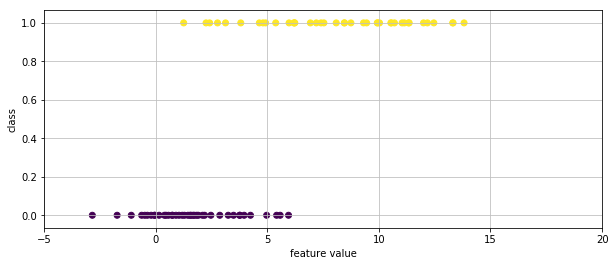

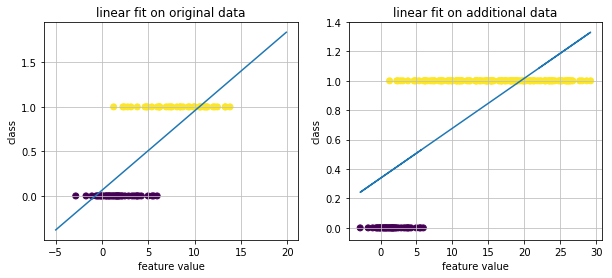

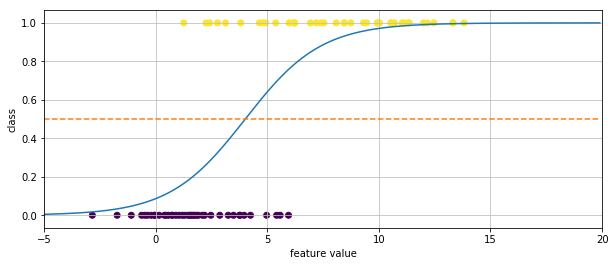

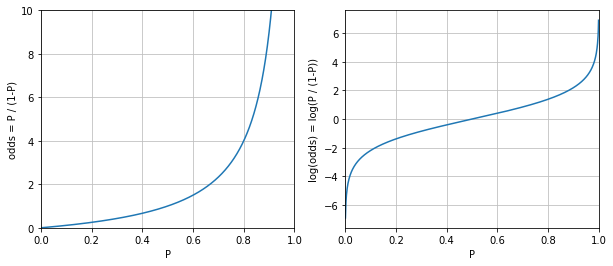

In [9]:

CHART_DIR ="./charts"

np.random.seed(42)

num_per_class = 40
X = np.hstack((norm.rvs(2, size=num_per_class, scale=2),
              norm.rvs(8, size=num_per_class, scale=3)))
y = np.hstack((np.zeros(num_per_class),
               np.ones(num_per_class)))


def lr_model(clf, X):
    return 1.0 / (1.0 + np.exp(-(clf.intercept_ + clf.coef_ * X)))

from sklearn.linear_model import LogisticRegression
logclf = LogisticRegression()
print(logclf)
logclf.fit(X.reshape(num_per_class * 2, 1), y)
print(np.exp(logclf.intercept_), np.exp(logclf.coef_.ravel()))
print("P(x=-1)=%.2f\tP(x=7)=%.2f" %
      (lr_model(logclf, -1), lr_model(logclf, 7)))
X_test = np.arange(-5, 20, 0.1)
pyplot.figure(figsize=(10, 4))
pyplot.xlim((-5, 20))
pyplot.scatter(X, y, c=y)
pyplot.xlabel("feature value")
pyplot.ylabel("class")
pyplot.grid(True, linestyle='-', color='0.75')
pyplot.savefig(
    os.path.join(CHART_DIR, "log_reg_example_data.png"), bbox_inches="tight")


def lin_model(clf, X):
    return clf.intercept_ + clf.coef_ * X

from sklearn.linear_model import LinearRegression
clf = LinearRegression()
print(clf)
clf.fit(X.reshape(num_per_class * 2, 1), y)
X_odds = np.arange(0, 1, 0.001)
pyplot.figure(figsize=(10, 4))
pyplot.subplot(1, 2, 1)
pyplot.scatter(X, y, c=y)
pyplot.plot(X_test, lin_model(clf, X_test))
pyplot.xlabel("feature value")
pyplot.ylabel("class")
pyplot.title("linear fit on original data")
pyplot.grid(True, linestyle='-', color='0.75')

X_ext = np.hstack((X, norm.rvs(20, size=100, scale=5)))
y_ext = np.hstack((y, np.ones(100)))
clf = LinearRegression()
clf.fit(X_ext.reshape(num_per_class * 2 + 100, 1), y_ext)
pyplot.subplot(1, 2, 2)
pyplot.scatter(X_ext, y_ext, c=y_ext)
pyplot.plot(X_ext, lin_model(clf, X_ext))
pyplot.xlabel("feature value")
pyplot.ylabel("class")
pyplot.title("linear fit on additional data")
pyplot.grid(True, linestyle='-', color='0.75')
pyplot.savefig(
    os.path.join(CHART_DIR, "log_reg_log_linear_fit.png"), bbox_inches="tight")

pyplot.figure(figsize=(10, 4))
pyplot.xlim((-5, 20))
pyplot.scatter(X, y, c=y)
pyplot.plot(X_test, lr_model(logclf, X_test).ravel())
pyplot.plot(X_test, np.ones(X_test.shape[0]) * 0.5, "--")
pyplot.xlabel("feature value")
pyplot.ylabel("class")
pyplot.grid(True, linestyle='-', color='0.75')
pyplot.savefig(
    os.path.join(CHART_DIR, "log_reg_example_fitted.png"), bbox_inches="tight")

X = np.arange(0, 1, 0.001)
pyplot.figure(figsize=(10, 4))
pyplot.subplot(1, 2, 1)
pyplot.xlim((0, 1))
pyplot.ylim((0, 10))
pyplot.plot(X, X / (1 - X))
pyplot.xlabel("P")
pyplot.ylabel("odds = P / (1-P)")
pyplot.grid(True, linestyle='-', color='0.75')

pyplot.subplot(1, 2, 2)
pyplot.xlim((0, 1))
pyplot.plot(X, np.log(X / (1 - X)))
pyplot.xlabel("P")
pyplot.ylabel("log(odds) = log(P / (1-P))")
pyplot.grid(True, linestyle='-', color='0.75')
pyplot.savefig(
    os.path.join(CHART_DIR, "log_reg_log_odds.png"), bbox_inches="tight")

## Helper Functions

In [28]:
CHART_DIR ="./charts"

def fetch_data(filename, col=None, line_count=-1, only_questions=False):
    count = 0

    for line in open(filename, "r"):
        count += 1
        if line_count > 0 and count > line_count:
            break

        data = Id, ParentId, IsQuestion, IsAccepted, TimeToAnswer, Score, Text, NumTextTokens, NumCodeLines, LinkCount, MisSpelledFraction = line.split(
            "\t")

        IsQuestion = int(IsQuestion)

        if only_questions and not IsQuestion:
            continue

        if col:
            if col < 6:
                val = int(data[col])
            else:
                val = data[col]

            yield val

        else:
            Id = int(Id)
            assert Id >= 0, line

            ParentId = int(ParentId)

            IsAccepted = int(IsAccepted)

            assert not IsQuestion == IsAccepted == 1, "%i %i --- %s" % (
                IsQuestion, IsAccepted, line)
            assert (ParentId == -1 and IsQuestion) or (
                ParentId >= 0 and not IsQuestion), "%i %i --- %s" % (ParentId, IsQuestion, line)

            TimeToAnswer = int(TimeToAnswer)
            Score = int(Score)
            NumTextTokens = int(NumTextTokens)
            NumCodeLines = int(NumCodeLines)
            LinkCount = int(LinkCount)
            MisSpelledFraction = float(MisSpelledFraction)
            yield Id, ParentId, IsQuestion, IsAccepted, TimeToAnswer, Score, Text, NumTextTokens, NumCodeLines, LinkCount, MisSpelledFraction


def fetch_posts(filename, with_index=True, line_count=-1):
    count = 0

    for line in open(filename, "r"):
        count += 1
        if line_count > 0 and count > line_count:
            break

        Id, Text = line.split("\t")
        Text = Text.strip()

        if with_index:

            yield int(Id), Text

        else:

            yield Text


def load_meta(filename):
    meta = json.load(open(filename, "r"))
    keys = list(meta.keys())

    # JSON only allows string keys, changing that to int
    for key in keys:
        meta[int(key)] = meta[key]
        del meta[key]

    # post Id to index in vectorized
    id_to_idx = {}
    # and back
    idx_to_id = {}

    for PostId, Info in meta.items():
        id_to_idx[PostId] = idx = Info['idx']
        idx_to_id[idx] = PostId

    return meta, id_to_idx, idx_to_id


def plot_roc(auc_score, name, fpr, tpr):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.plot([0, 1], [0, 1], 'k--')
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('False Positive Rate')
    pylab.ylabel('True Positive Rate')
    pylab.title('Receiver operating characteristic (AUC=%0.2f)\n%s' % (
        auc_score, name))
    pylab.legend(loc="lower right")
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.fill_between(tpr, fpr, alpha=0.5)
    pylab.plot(fpr, tpr, lw=1)
    pylab.savefig(
        os.path.join(CHART_DIR, "roc_" + name.replace(" ", "_") + ".png"))


def plot_pr(auc_score, name, precision, recall, label=None):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.xlim([0.0, 1.0])
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Recall')
    pylab.ylabel('Precision')
    pylab.title('P/R (AUC=%0.2f) / %s' % (auc_score, label))
    pylab.fill_between(recall, precision, alpha=0.5)
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.plot(recall, precision, lw=1)
    filename = name.replace(" ", "_")
    pylab.savefig(os.path.join(CHART_DIR, "pr_" + filename + ".png"))


def show_most_informative_features(vectorizer, clf, n=20):
    c_f = sorted(zip(clf.coef_[0], vectorizer.get_feature_names()))
    top = list(zip(c_f[:n], c_f[:-(n + 1):-1]))
    for (c1, f1), (c2, f2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (c1, f1, c2, f2))


def plot_feat_importance(feature_names, clf, name):
    pylab.figure(num=None, figsize=(6, 5))
    coef_ = clf.coef_
    important = np.argsort(np.absolute(coef_.ravel()))
    f_imp = feature_names[important]
    coef = coef_.ravel()[important]
    inds = np.argsort(coef)
    f_imp = f_imp[inds]
    coef = coef[inds]
    xpos = np.array(list(range(len(coef))))
    pylab.bar(xpos, coef, width=1)

    pylab.title('Feature importance for %s' % (name))
    ax = pylab.gca()
    ax.set_xticks(np.arange(len(coef)))
    labels = ax.set_xticklabels(f_imp)
    for label in labels:
        label.set_rotation(90)
    filename = name.replace(" ", "_")
    pylab.savefig(os.path.join(
        CHART_DIR, "feat_imp_%s.png" % filename), bbox_inches="tight")


def plot_feat_hist(data_name_list, filename=None):
    if len(data_name_list) > 1:
        assert filename is not None

    pylab.figure(num=None, figsize=(8, 6))
    num_rows = int(1 + (len(data_name_list) - 1) / 2)
    num_cols = int(1 if len(data_name_list) == 1 else 2)
    pylab.figure(figsize=(5 * num_cols, 4 * num_rows))

    for i in range(num_rows):
        for j in range(num_cols):
            pylab.subplot(num_rows, num_cols, 1 + i * num_cols + j)
            x, name = data_name_list[i * num_cols + j]
            pylab.title(name)
            pylab.xlabel('Value')
            pylab.ylabel('Fraction')
            # the histogram of the data
            max_val = np.max(x)
            if max_val <= 1.0:
                bins = 50
            elif max_val > 50:
                bins = 50
            else:
                bins = max_val
            n, bins, patches = pylab.hist(x, bins=int(bins), normed=1, alpha=0.75)

            pylab.grid(True)

    if not filename:
        filename = "feat_hist_%s.png" % name.replace(" ", "_")

    pylab.savefig(os.path.join(CHART_DIR, filename), bbox_inches="tight")


def plot_bias_variance(data_sizes, train_errors, test_errors, name, title):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('Data set size')
    pylab.ylabel('Error')
    pylab.title("Bias-Variance for '%s'" % name)
    pylab.plot(
        data_sizes, test_errors, "--", data_sizes, train_errors, "b-", lw=1)
    pylab.legend(["test error", "train error"], loc="upper right")
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.savefig(
        os.path.join(CHART_DIR, "bv_" + name.replace(" ", "_") + ".png"), bbox_inches="tight")


def plot_k_complexity(ks, train_errors, test_errors):
    pylab.figure(num=None, figsize=(6, 5))
    pylab.ylim([0.0, 1.0])
    pylab.xlabel('k')
    pylab.ylabel('Error')
    pylab.title('Errors for for different values of $k$')
    pylab.plot(
        ks, test_errors, "--", ks, train_errors, "-", lw=1)
    pylab.legend(["test error", "train error"], loc="upper right")
    pylab.grid(True, linestyle='-', color='0.75')
    pylab.savefig(
        os.path.join(CHART_DIR, "kcomplexity.png"), bbox_inches="tight")

## Classification 

In [29]:
import time

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn import neighbors

import nltk
nltk.download('punkt')
# run this

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Predator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [30]:
start_time = time.time()

# question Id -> {'features'->feature vector, 'answers'->[answer Ids]}, 'scores'->[scores]}
# scores will be added on-the-fly as the are not in meta
meta, id_to_idx, idx_to_id = load_meta(chosen_meta)

# The sorting below is only to ensure reproducable numbers. Further down
# we will occasionally skip a fold when it contains instances of only
# one label. The two lines below ensure that the behavior is exactly the
# same for different runs.
all_questions = sorted([q for q, v in meta.items() if v['ParentId'] == -1])
all_answers = sorted([q for q, v in meta.items() if v['ParentId'] != -1])

feature_names = np.array((
    'NumTextTokens',
    'NumCodeLines',
    'LinkCount',
    'AvgSentLen',
    'AvgWordLen',
    'NumAllCaps',
    'NumExclams',
    'NumImages'
))


def prepare_sent_features():
    for pid, text in fetch_posts(chosen, with_index=True):
        if not text:
            meta[pid]['AvgSentLen'] = meta[pid]['AvgWordLen'] = 0
        else:
            from platform import python_version
            if python_version().startswith('2'):
                text = text.decode('utf-8')
            sent_lens = [len(nltk.word_tokenize(
                sent)) for sent in nltk.sent_tokenize(text)]
            meta[pid]['AvgSentLen'] = np.mean(sent_lens)
            meta[pid]['AvgWordLen'] = np.mean(
                [len(w) for w in nltk.word_tokenize(text)])

        meta[pid]['NumAllCaps'] = np.sum(
            [word.isupper() for word in nltk.word_tokenize(text)])

        meta[pid]['NumExclams'] = text.count('!')


prepare_sent_features()


def get_features(aid):
    return tuple(meta[aid][fn] for fn in feature_names)

qa_X = np.asarray([get_features(aid) for aid in all_answers])

classifying_answer = "good"
#classifying_answer = "poor"

if classifying_answer == "good":
    # Score > 0 tests => positive class is good answer
    qa_Y = np.asarray([meta[aid]['Score'] > 0 for aid in all_answers])
elif classifying_answer == "poor":
    # Score <= 0 tests => positive class is poor answer
    qa_Y = np.asarray([meta[aid]['Score'] <= 0 for aid in all_answers])
else:
    raise Exception("classifying_answer='%s' is not supported" %
                    classifying_answer)




In [31]:
for idx, feat in enumerate(feature_names):
#     print (idx,feat)
#     print([(qa_X[:, idx], feat)])
    plot_feat_hist([(qa_X[:, idx], feat)])

plot_feat_hist([(qa_X[:, idx], feature_names[idx]) for idx in [1,0]], 'feat_hist_two.png')
plot_feat_hist([(qa_X[:, idx], feature_names[idx]) for idx in [3,4,5,6]], 'feat_hist_four.png')

avg_scores_summary = []


In [32]:
def measure(clf_class, parameters, name, data_size=None, plot=False):
    start_time_clf = time.time()
    if data_size is None:
        X = qa_X
        Y = qa_Y
    else:
        X = qa_X[:data_size]
        Y = qa_Y[:data_size]

    cv = KFold(n=len(X), n_folds=10)

    train_errors = []
    test_errors = []

    scores = []
    roc_scores = []
    fprs, tprs = [], []

    pr_scores = []
    precisions, recalls, thresholds = [], [], []

    for fold_idx, (train, test) in enumerate(cv):
        X_train, y_train = X[train], Y[train]
        X_test, y_test = X[test], Y[test]

        only_one_class_in_train = len(set(y_train)) == 1
        only_one_class_in_test = len(set(y_test)) == 1
        if only_one_class_in_train or only_one_class_in_test:
            # this would pose problems later on
            continue

        clf = clf_class(**parameters)

        clf.fit(X_train, y_train)

        train_score = clf.score(X_train, y_train)
        test_score = clf.score(X_test, y_test)

        train_errors.append(1 - train_score)
        test_errors.append(1 - test_score)

        scores.append(test_score)
        proba = clf.predict_proba(X_test)

        label_idx = 1
        fpr, tpr, roc_thresholds = roc_curve(y_test, proba[:, label_idx])
        precision, recall, pr_thresholds = precision_recall_curve(
            y_test, proba[:, label_idx])

        roc_scores.append(auc(fpr, tpr))
        fprs.append(fpr)
        tprs.append(tpr)

        pr_scores.append(auc(recall, precision))
        precisions.append(precision)
        recalls.append(recall)
        thresholds.append(pr_thresholds)

        # This threshold is determined at the end of the chapter 5,
        # where we find conditions such that precision is in the area of
        # about 80%. With it we trade off recall for precision.
        threshold_for_detecting_good_answers = 0.59

        print("Clone #%i" % fold_idx)
        print(classification_report(y_test, proba[:, label_idx] >
              threshold_for_detecting_good_answers, target_names=['not accepted', 'accepted']))

    # get medium clone
    scores_to_sort = pr_scores  # roc_scores
    medium = np.argsort(scores_to_sort)[int(len(scores_to_sort) / 2)]
    print("Medium clone is #%i" % medium)

    if plot:
        #plot_roc(roc_scores[medium], name, fprs[medium], tprs[medium])
        plot_pr(pr_scores[medium], name, precisions[medium],
                recalls[medium], classifying_answer + " answers")

        if hasattr(clf, 'coef_'):
            plot_feat_importance(feature_names, clf, name)

    summary = (name,
               np.mean(scores), np.std(scores),
               np.mean(roc_scores), np.std(roc_scores),
               np.mean(pr_scores), np.std(pr_scores),
               time.time() - start_time_clf)
    print(summary)
    avg_scores_summary.append(summary)
    precisions = precisions[medium]
    recalls = recalls[medium]
    thresholds = np.hstack(([0], thresholds[medium]))
    idx80 = precisions >= 0.8
    print("P=%.2f R=%.2f thresh=%.2f" % (precisions[idx80][0], recalls[
          idx80][0], thresholds[idx80][0]))

    return np.mean(train_errors), np.mean(test_errors)




In [33]:

def bias_variance_analysis(clf_class, parameters, name):
    #import ipdb;ipdb.set_trace()
    data_sizes = np.arange(60, 2000, 4)

    train_errors = []
    test_errors = []

    for data_size in data_sizes:
        train_error, test_error = measure(clf_class, parameters, name, data_size=data_size)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_bias_variance(data_sizes, train_errors,
                       test_errors, name, "Bias-Variance for '%s'" % name)



In [34]:
def k_complexity_analysis(clf_class, parameters):
    ks = np.hstack((np.arange(1, 20), np.arange(21, 100, 5)))

    train_errors = []
    test_errors = []

    for k in ks:
        parameters['n_neighbors'] = k
        train_error, test_error = measure(
            clf_class, parameters, "%dNN" % k, data_size=2000)
        train_errors.append(train_error)
        test_errors.append(test_error)

    plot_k_complexity(ks, train_errors, test_errors)


Clone #0
              precision    recall  f1-score   support

not accepted       0.33      0.50      0.40         2
    accepted       0.67      0.50      0.57         4

 avg / total       0.56      0.50      0.51         6

Clone #1
              precision    recall  f1-score   support

not accepted       0.00      0.00      0.00         2
    accepted       0.60      0.75      0.67         4

 avg / total       0.40      0.50      0.44         6

Clone #2
              precision    recall  f1-score   support

not accepted       0.33      1.00      0.50         1
    accepted       1.00      0.60      0.75         5

 avg / total       0.89      0.67      0.71         6

Clone #3
              precision    recall  f1-score   support

not accepted       0.00      0.00      0.00         3
    accepted       0.40      0.67      0.50         3

 avg / total       0.20      0.33      0.25         6

Clone #4
              precision    recall  f1-score   support

not accepted       0.00 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Clone #1
              precision    recall  f1-score   support

not accepted       0.20      1.00      0.33         1
    accepted       1.00      0.43      0.60         7

 avg / total       0.90      0.50      0.57         8

Clone #2
              precision    recall  f1-score   support

not accepted       0.67      0.50      0.57         4
    accepted       0.60      0.75      0.67         4

 avg / total       0.63      0.62      0.62         8

Clone #3
              precision    recall  f1-score   support

not accepted       0.50      0.50      0.50         2
    accepted       0.83      0.83      0.83         6

 avg / total       0.75      0.75      0.75         8

Clone #4
              precision    recall  f1-score   support

not accepted       0.33      1.00      0.50         2
    accepted       1.00      0.33      0.50         6

 avg / total       0.83      0.50      0.50         8

Clone #5
              precision    recall  f1-score   support

not accepted       0.00 

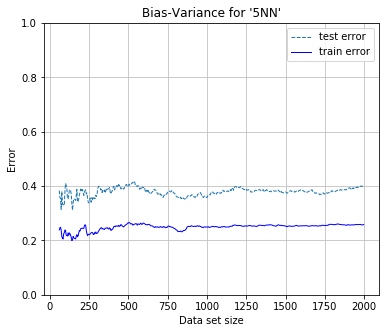

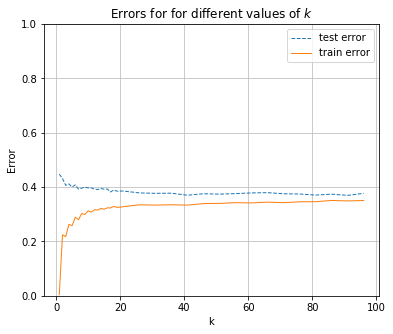

In [42]:

for k in [5]:
# for k in [5, 10, 40]:
    #measure(neighbors.KNeighborsClassifier, {'n_neighbors': k}, "%iNN" % k)
    bias_variance_analysis(neighbors.KNeighborsClassifier, {'n_neighbors': k}, "%iNN" % k)
    k_complexity_analysis(neighbors.KNeighborsClassifier, {'n_neighbors': k})



Clone #0
              precision    recall  f1-score   support

not accepted       0.50      0.50      0.50         2
    accepted       0.75      0.75      0.75         4

 avg / total       0.67      0.67      0.67         6

Clone #1
              precision    recall  f1-score   support

not accepted       0.33      0.50      0.40         2
    accepted       0.67      0.50      0.57         4

 avg / total       0.56      0.50      0.51         6

Clone #2
              precision    recall  f1-score   support

not accepted       0.33      1.00      0.50         1
    accepted       1.00      0.60      0.75         5

 avg / total       0.89      0.67      0.71         6

Clone #3
              precision    recall  f1-score   support

not accepted       0.50      0.67      0.57         3
    accepted       0.50      0.33      0.40         3

 avg / total       0.50      0.50      0.49         6

Clone #4
              precision    recall  f1-score   support

not accepted       0.00 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Clone #8
              precision    recall  f1-score   support

not accepted       1.00      0.50      0.67         2
    accepted       0.86      1.00      0.92         6

 avg / total       0.89      0.88      0.86         8

Clone #9
              precision    recall  f1-score   support

not accepted       0.50      0.33      0.40         3
    accepted       0.67      0.80      0.73         5

 avg / total       0.60      0.62      0.60         8

Medium clone is #1
('LogReg C=0.10', 0.6277777777777779, 0.09229582069908972, 0.7636507936507937, 0.16269872241550082, 0.8969396258503401, 0.06801268160282249, 0.023935317993164062)
P=0.86 R=0.86 thresh=0.42
Clone #0
              precision    recall  f1-score   support

not accepted       0.40      0.67      0.50         3
    accepted       0.80      0.57      0.67         7

 avg / total       0.68      0.60      0.62        10

Clone #1
              precision    recall  f1-score   support

not accepted       0.38      1.00      0.55 

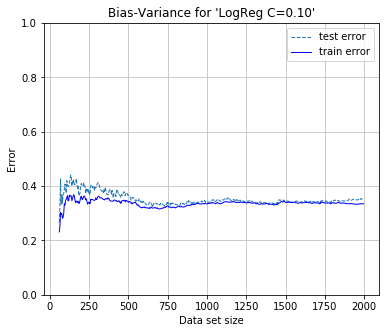

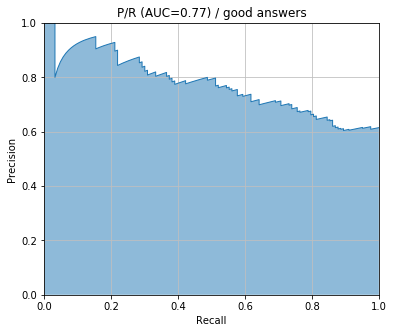

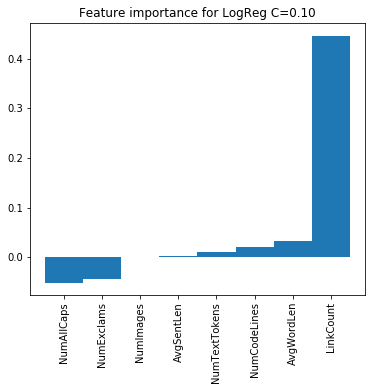

In [43]:
from sklearn.linear_model import LogisticRegression
for C in [0.1]:
# for C in [0.01, 0.1, 1.0, 10.0]:
    name = "LogReg C=%.2f" % C
    bias_variance_analysis(LogisticRegression, {'penalty': 'l2', 'C': C}, name)
    measure(LogisticRegression, {'penalty': 'l2', 'C': C}, name, plot=True)

print("=" * 50)
from operator import itemgetter
for s in reversed(sorted(avg_scores_summary, key=itemgetter(1))):
    print("%-20s\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f\t%.5f" % s)

print("time spent:", time.time() - start_time)